In [1]:
import epics
import numpy
import pandas
import torch
import nufft

import sys
sys.path.append('..')

from harmonica.util import LIMIT
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


# Example-01: Estimation of parameters (harmonic sum)

In [2]:
# Estimate parameters and standard errors (random frequency)

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.1), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.5)])

# Estimate parameters and errors (direct)
p1, s1 = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate parameters and errors (automatic)
p2, s2 = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate errors (average over noise realizations)
box = []
for _ in range(8192):
    y = x + s_x.reshape(-1, 1)*torch.randn_like(x, dtype=dtype, device=device)
    out, _ = Decomposition.harmonic_sum(0.12 + 1.0E-5*torch.randn(1, dtype=dtype, device=device), w.window, y)
    box.append(out)    
box = torch.stack(box).T.std(-1).T

# Compare parameters
print(p1)
print(p2)
print()

# Compare errors
print(s1)
print(s2)
print(box)
print()

tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)
tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)

tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.834816792201e-03, 8.390448345788e-03, 2.716646453767e-03, 3.372526053267e-02],
        [1.154925258432e-02, 2.105440121869e-02, 5.388145843367e-04, 

# Example-02: Estimation of parameters (harmonic sum & batched mode)

In [3]:
# Estimate parameters and errors for a batch of frequencies

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 1.0, dtype=torch.float64, device='cpu')

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.60)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25), 0.25*torch.cos(2.0*numpy.pi*0.24*t + 0.15)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10), 0.01*torch.cos(2.0*numpy.pi*0.36*t + 0.50)])
x = x1 + x2 + x3

# Compute parameters and errors for each frequency (direct)
p1a, s1a = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1b, s1b = Decomposition.harmonic_sum(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1c, s1c = Decomposition.harmonic_sum(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1 = torch.stack([p1a, p1b, p1c])
s1 = torch.stack([s1a, s1b, s1c])

# Compute parameters and errors for each frequency (automatic)
p2a, s2a = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2b, s2b = Decomposition.harmonic_sum_automatic(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2c, s2c = Decomposition.harmonic_sum_automatic(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2 = torch.stack([p2a, p2b, p2c])
s2 = torch.stack([s2a, s2b, s2c])

# Compute parameters and errors for each frequency (batched)
p3, s3 = Decomposition.harmonic_sum_batched(
    torch.tensor([0.12, 0.24, 0.36], dtype=dtype, device=device),
    w.window,
    x,
    error=True,
    sigma=s_x,
    sigma_frequency=torch.tensor([s_f, s_f, s_f], dtype=dtype, device=device))

# Compare errors
print(s1)
print(s2)
print(s3)

tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.706329386826e-03, 6.296499040365e-02],
         [5.628105253876e-04, 6.104693260486e-04, 5.412658773675e-04, 6.296490438044e-02]]],
       dtype=torch.float64)
tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.

In [4]:
# Estimate parameters for a list of harmonics

# Set parameters
length = 2048
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 4.0, dtype=torch.float64, device='cpu')

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10)])
x = x1 + x2 + x3

# Set harmonics
f = 0.12
h = torch.tensor([*Frequency.harmonics(10, [f]).values()], dtype=dtype, device=device)

# Estimate parameters
param, _ = Decomposition.harmonic_sum_batched(h, w.window, x, error=False)

# Result (amplitude)
*_, a, _ = param.T
print(a.T)

tensor([[2.500000000000e-01],
        [1.000000000000e-01],
        [5.000000000000e-02],
        [2.623619031558e-16],
        [4.015512494878e-16],
        [3.147267753522e-16],
        [1.854150954133e-16],
        [1.135456674832e-16],
        [7.519772959361e-16],
        [2.807503616015e-16]], dtype=torch.float64)


# Example-03: Estimator bias

w1: 2.09465512e-05 2.2936407e-06
w2: 3.7373038e-09 4.98039843e-09


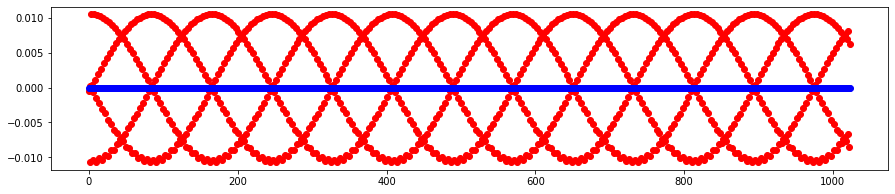

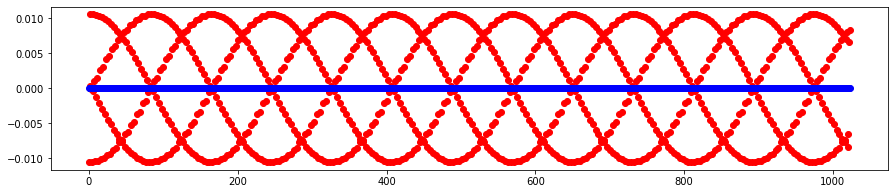

In [5]:
# Given a noise-free signal containing several components
# Parameters for a given frequency can be estimated using (weighted) harmonic sum
# Estimated values depend on the length used for estimation and as well as on the signal starting position
# In this example, estimator bias is explored
# Ensembling several estimators (fixed length and different starting position) in general will improve estimation accuracy (reduce bias)

# Set parameters
length = 8192
dtype = torch.float64
device = 'cpu'

# Set signal
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x = torch.stack([x])

# Set shift size for starting position
shift = 1

# Set window
w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 1.0, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Change window order, sample length and/or number of samples to observe convergents
limit = 1024
A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    
    y = x[:, step*shift: step*shift + 128]
    
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)
    
# Format result (amplitude is constant, while phase is shifted)
A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = Frequency.mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = Frequency.mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples
print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), A1 - 1.00, c='red')
plt.scatter(range(limit), A2 - 1.00, c='blue')
plt.show()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), B1 - 0.25, c='red')
plt.scatter(range(limit), B2 - 0.25, c='blue')
plt.show()

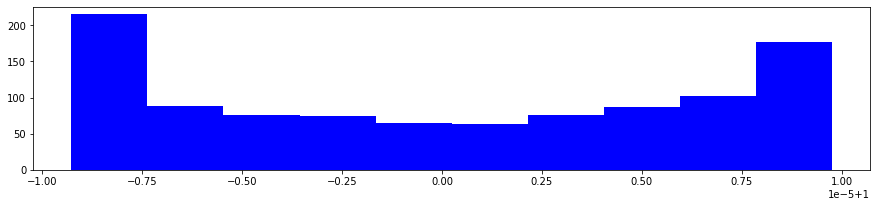

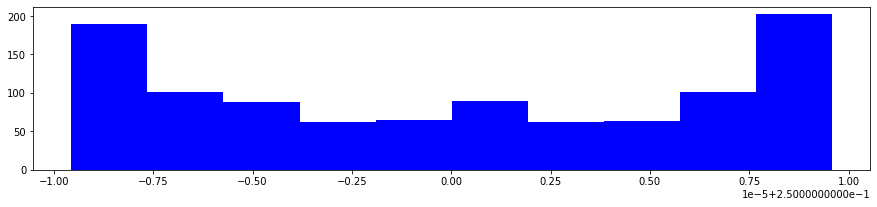

In [6]:
# Plot histogram

plt.figure(figsize=(15, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution is not normal (not random)
# It is not symmetric if signal containes more than one component

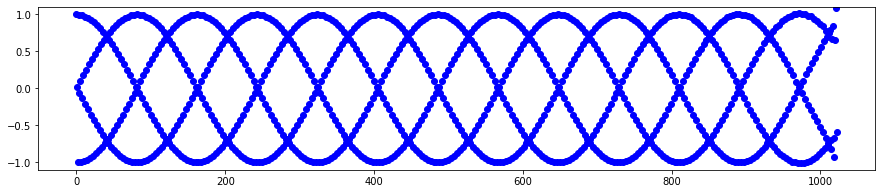

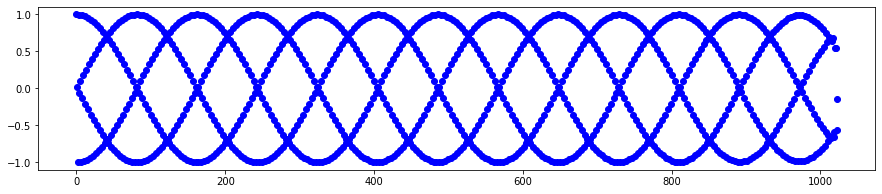

In [7]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

w1: 3.06178779e-05 5.54418857e-06
w2: 5.35752057e-05 9.09371925e-06


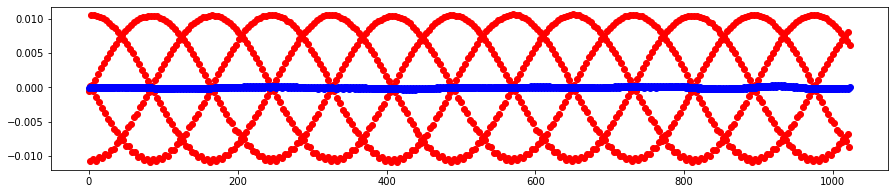

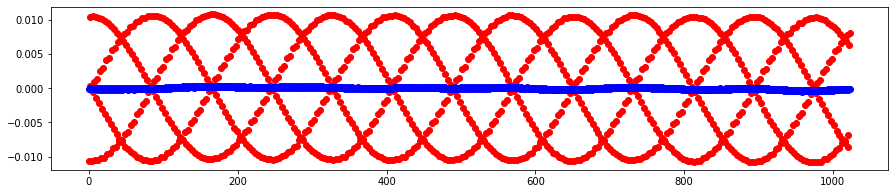

In [8]:
# Estimate parameters for signal with noise

# Set parameters
length = 8192
dtype = torch.float64
device = 'cpu'

# Set signal
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x.add_(0.001*torch.randn(length, dtype=dtype, device=device))
x = torch.stack([x])

# Set shift size for starting position
shift = 1

# Set window
# Note, without noise window increases convergence
# With noise window amplifies noise and should be use with care if noise is large
# A possible option is to filter data or to use fractional window order
w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 0.5, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Note, noise is correlated
A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    y = x[:, step*shift: step*shift + 128]
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)

# Format result (amplitude is constant, while phase is shifted)
A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = Frequency.mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = Frequency.mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples
print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), A1 - 1.00, c='red')
plt.scatter(range(limit), A2 - 1.00, c='blue')
plt.show()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), B1 - 0.25, c='red')
plt.scatter(range(limit), B2 - 0.25, c='blue')
plt.show()

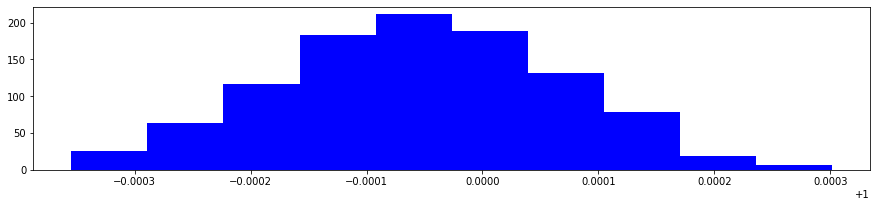

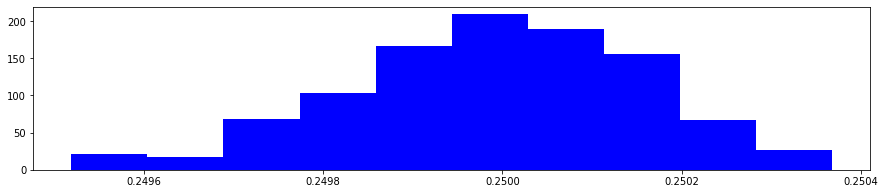

In [9]:
# Plot histogram

plt.figure(figsize=(15, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution looks somewhat not normal

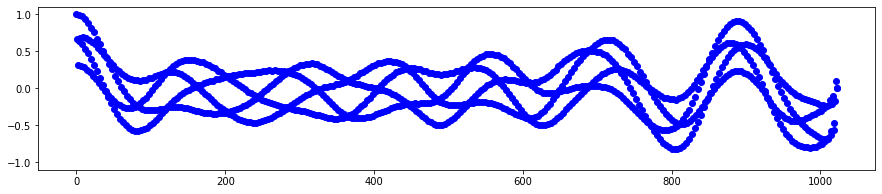

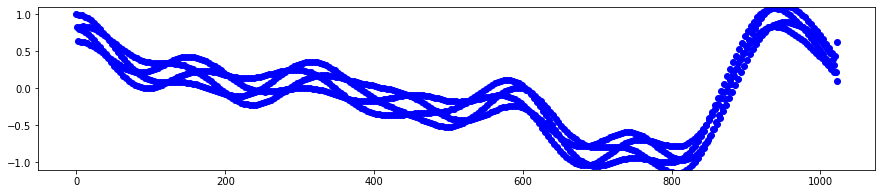

In [10]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

# Example-04: Amplitude estimation loop

In [11]:
# In this example amplitude estimation loop is described
# Amplitude and its error is estimated for given frequency using different methods

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


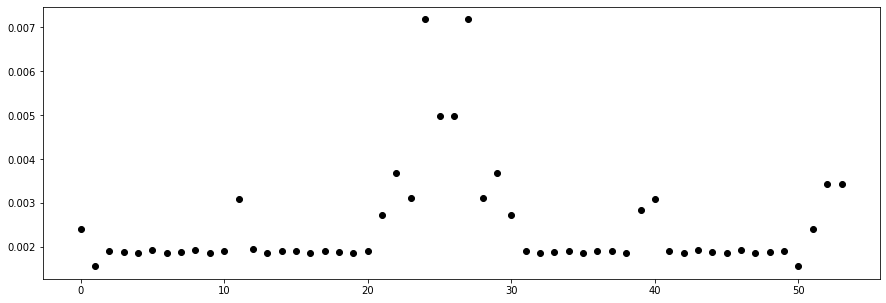

In [12]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

# Plot amplitude
plt.figure(figsize=(15, 5))
plt.scatter(range(54), amplitude.cpu(), color='black')
plt.show()

In [13]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 256 for amplitude

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536882932, spread=1.19047145e-06


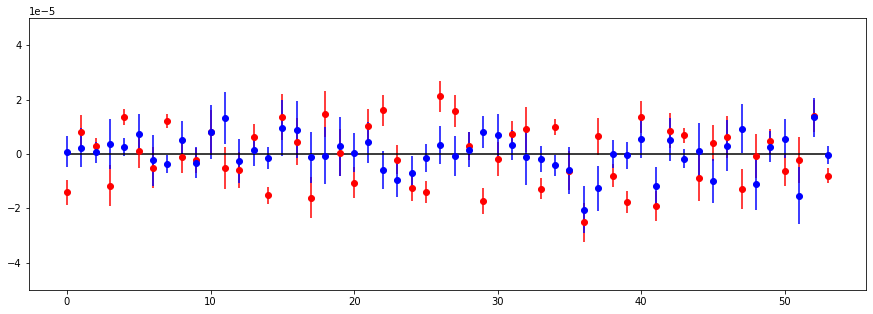

In [14]:
# Amplitude (and its error) can be estimated using harmonic_amplitude method
dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation without window (noise is estimated using optimal SVD truncation)
out1, err1 = dec.harmonic_amplitude(frequency, length=256, order=0.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread using error propogation with window
out2, err2 = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Compare results
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

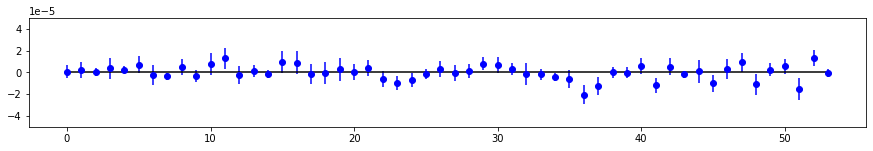

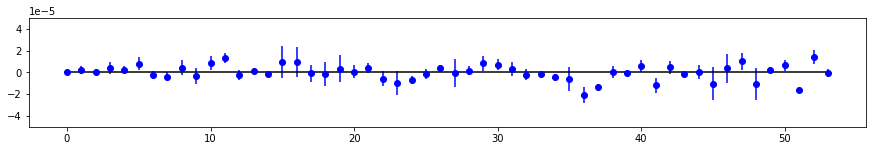

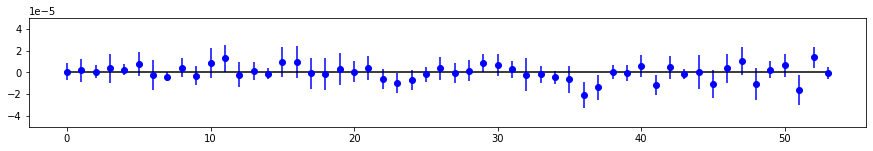

In [15]:
# Sampling can be used to improve estimation accuracy (sampling reduce effect of bias)
dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation
out1, err1 = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread from shifted samples
out2, err2 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='none')
out3, err3 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

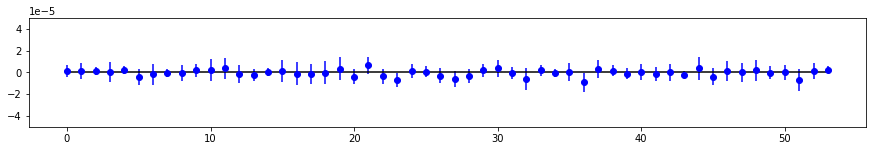

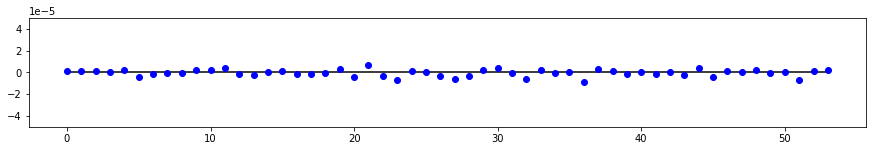

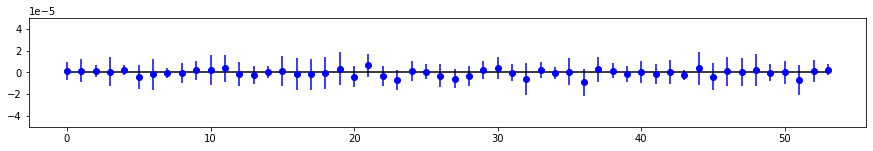

In [16]:
# Filter data
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)

# Estimate amplitude
dec = Decomposition(d)
out1, err1 = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)
out2, err2 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='none')
out3, err3 = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

d.reset()

# Example-05: Phase estimation loop

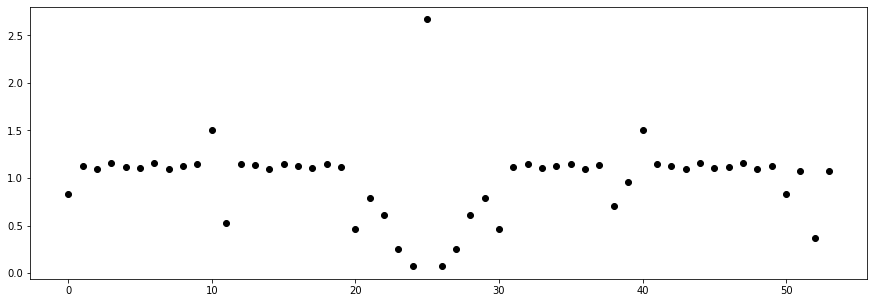

In [17]:
# Load phase advance data
df = pandas.read_json('../bpm.json')
advance = numpy.array([df[name]['FX'] for name in df])
plt.figure(figsize=(15, 5))
plt.scatter(range(54), advance, color='black')
plt.show()

In [18]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


In [19]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 512 for phase

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883185, spread=1.00586189e-06


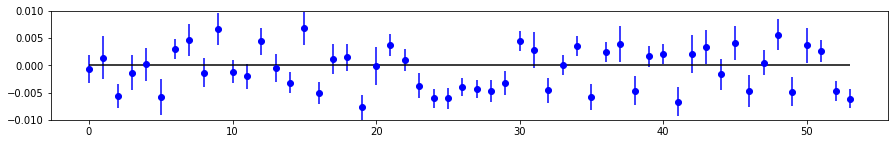

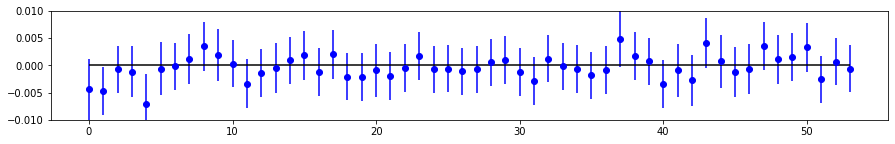

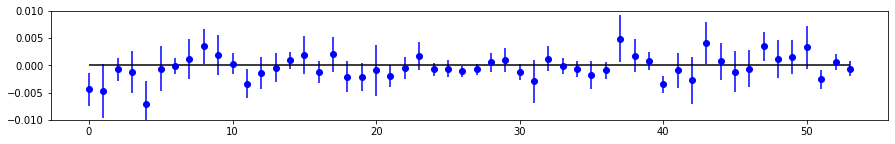

tensor(4.014103060868e-03, dtype=torch.float64)
tensor(2.242807898698e-03, dtype=torch.float64)
tensor(2.242807898698e-03, dtype=torch.float64)


In [20]:
# Estimate phase
dec = Decomposition(d)
out1, err1 = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='none')
out3, err3 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((out1 - phase).std())
print((out2 - phase).std())
print((out3 - phase).std())

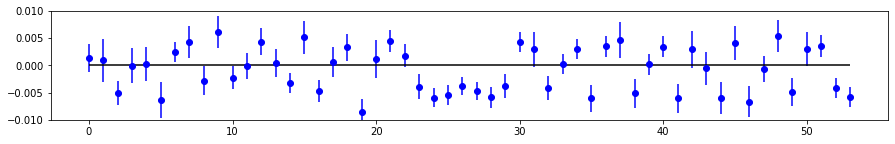

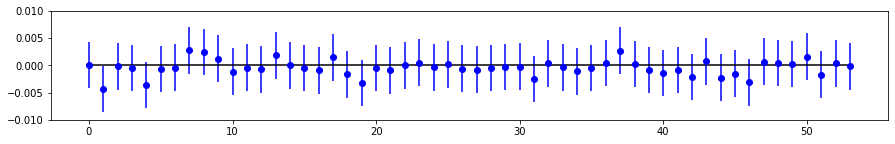

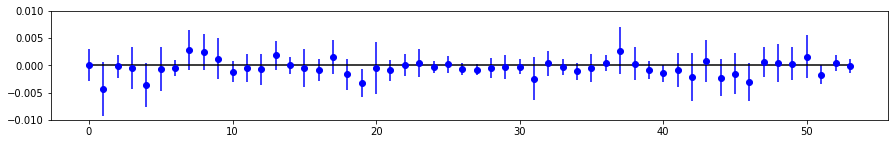

tensor(4.127590393562e-03, dtype=torch.float64)
tensor(1.450371431563e-03, dtype=torch.float64)
tensor(1.450371431563e-03, dtype=torch.float64)


In [21]:
# Estimate phase (filter)
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)
out1, err1 = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='none')
out3, err3 = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((out1 - phase).std())
print((out2 - phase).std())
print((out3 - phase).std())

d.reset()

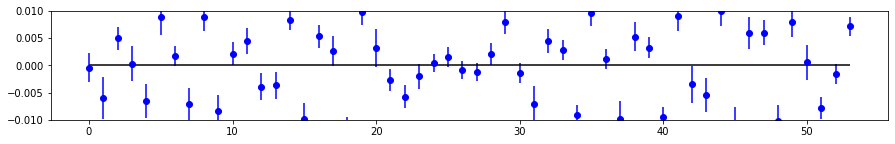

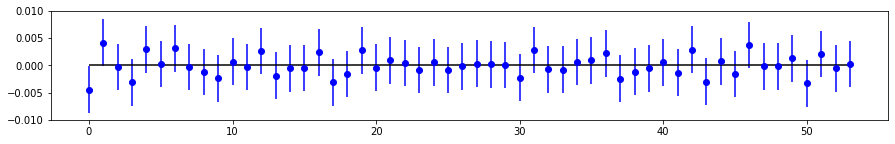

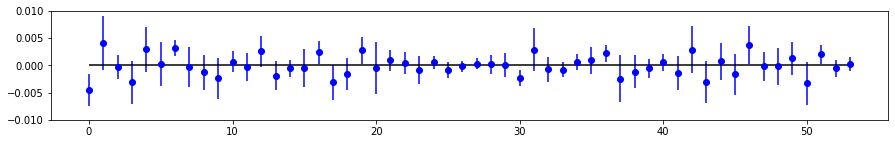

tensor(6.426502038385e-03, dtype=torch.float64)
tensor(1.922381132496e-03, dtype=torch.float64)
tensor(1.922381132496e-03, dtype=torch.float64)


In [22]:
# Compute and compare phase advance for the last case
add1, std1 = Decomposition.advance_adjacent(frequency, out1, sigma_phase=err1, sigma_frequency=spread)
add2, std2 = Decomposition.advance_adjacent(frequency, out2, sigma_phase=err2, sigma_frequency=spread)
add3, std3 = Decomposition.advance_adjacent(frequency, out3, sigma_phase=err3, sigma_frequency=spread)

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add1 - advance).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add2 - advance).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add3 - advance).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((add1 - advance).std())
print((add2 - advance).std())
print((add3 - advance).std())

# Example-06: Synchronization test